<center><img src="https://pbs.twimg.com/media/FommiJ9WIAEBPI0.jpg" width="500" /></center>
    
 <center> 

# Fase Nacional
## Prediccion - Equipo **Malbecs**

</center>

**Integrantes**

- Denis Trosman
- Vito Stamatti
- Sumit Kumar Jethani Jethani

# Contenido

El presente notebook se estructura de la siguiente manera

1. Preproceso UH_2023_TRAIN.txt 
2. Ingenieria de Variables de UH_2023_TRAIN.txt
3. Preproceso DATOS_ETO.txt
4. Ingenieria de Variablesde DATOS_ETO.txt
5. Ingenieria de Variables de DATOS_METEO.txt
6. Entrenamiento y Validacion
7. Prediccion Final

## Transparencia

Memoria del modelo

- Instrucciones de uso 
- Tratamientos sobre los datasets de datos 
- Elección de la muestra de entrenamiento y validación 
- Argumento de la tipología del modelo a desarrollar 
- Criterios aplicados para la selección del ganador 
- Visualización y explicación de los resultados


Consideramos que todos estos puntos fueron tratados correctamente en el script de Predicción. En este, comentamos claramente los pasos seguidos y motivos por los cuales fuimos generando determinadas funciones o dejando de lado variables.

A la hora de seleccionar el modelo ganador, no solo hemos evaluado el puntaje para nuestro set de evaluación, sino tambien que tan bien le fue a este en los años pasados. Tambien tuvimos en cuenta la interpretación del modelo y los tiempos de ejecución de estos, logrando un alto nivel de transparencia.

Esto se plasmó luego en la memoria adjuntada en la entrega final, donde se explica el funcionamiento del modelo y se favorece así el entendimiento por parte del usuario final.

Así mismo, realizamos un DASHBOARD adjunto donde permitimos la facil revisión de predicciones y analisis de errores cometidos por los modelos. En este, es posible filtrar para revisar caso por caso las predicciones de 2022, como tambien los errores en 2021.

# 1. Preproceso UH_2023_TRAIN.txt

Importamos librerias y pasamos paths donde estan ubicados los datos

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  
import seaborn as sns


from malbecs.preprocess import wine as wine_pr
from malbecs.feateng import wine as wine_fe

import warnings
warnings.filterwarnings('ignore')

seed = 42
raw_wine_path = "../data/raw/UH_2023_TRAIN.txt"
pro_wine_path = "../data/processed/wine_pro.csv" 
final_wine_path = "../data/final/wine_final.csv" 

Carga de datos

In [2]:
wine_data = wine_pr.load_wine_dataset(raw_wine_path)
wine_data.sample(5, random_state=seed)

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
1318,15,68089,506,16,600-620,26,2,0,1,0.00,5799.42
9504,22,91845,47,19,520-540,38,2,0,0,0.69,NaN
7222,20,95959,299,12,440-450,17,1,0,1,0.55,1040.00
5391,18,53298,473,10,450-480,9,1,0,0,0.00,740.00
9166,22,2913,449,3,550-700,52,2,0,1,1.33,NaN


Englobamos transfomaciones en una funcion propia llamada **preprocess_wine_data**, donde aplicamos:

- Conversion de altitud en formato texto a formato numerico. Se utiliza el promedio de altitudes en el caso de haber 2 valores presentes
- Reemplazamos valores en 0 por nulos para ser imputados posteriormente
- Imputacion de altitud promedio por estacion
- Imputacion jerarquica de superficie por agrupada por diferentes niveles de agregacion.

In [3]:
wine_data = wine_pr.preproces_wine_data(wine_data)
wine_data.sample(5, random_state=seed)

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion,std_superficie,std_superficie_null,sup_is_nan
1318,15,68089,506,16,610.00,26,2,0,1,2.40,5799.42,0.00,True,1.00
9504,22,91845,47,19,530.00,38,2,0,0,0.69,NaN,0.00,True,0.00
7222,20,95959,299,12,445.00,17,1,0,1,0.55,1040.00,0.00,True,0.00
5391,18,53298,473,10,465.00,9,1,0,0,0.70,740.00,NaN,False,1.00
9166,22,2913,449,3,625.00,52,2,0,1,1.33,NaN,0.45,False,0.00


### Feature engineering:  

A lo largo del procesamiento de los datos, se crearon las siguientes variables:

- std_superficie_null: si el desvio estandard de la superficie para la finca-variedad-modo es nulo
- std_superficie: el desvio estandar de la superficie para esta finca-variedad-modo
- sup_is_nan: si la superficie era nula y por lo tanto fue imputada
- sup_tot_camp_finca: la superficie total de esta finca para la campaña
- superficie_total: la superficie total media de la finca.
- n_var_camp_finca: cantidad de variedades diferences cultivadas en una finca
- prod_shift1: produccion de la finca- teniendo en cuenta variables que la hacen unica- en la campaña anterior
- prod_shift2: produccion de la finca- teniendo en cuenta variables que la hacen unica- dos campañas anteriores
- sup_shift1: superficie de la finca en la campaña anterior
- sup_shift2: superficie de la finca dos campañas anteriores
- prod_shift1_gt_shift2: si la produccion de la campaña anterior fue mayor a la de dos anteriores
- prod_shift_max: la maxima producion entre la campaña anterior y dos anteriores.
- prod_shift_change: cambio entre la produccion de la campaña anterior y las dos anteriores.
- prod_shift_avg: promedio de la produccion de la campaña anterior y dos anteriores.
- prod_est_mean_change: cambio en la produccion media de la estacion para la campaña anterior y dos anteriores.
- prod_he_shift1: produccion por hectarea de la campaña anterior
- prod_he_shift2: produccion por hectarea de dos campañas anteriores.
- prod_he_shift_change: cambio de produccion por hectarea entre la campaña anterior y dos anteriores.
- prod_he_shift_avg: produccion por hectarea promedio entre la campaña anterior y dos anteriores.
- prod_he_var_zone_mean_hist: promedio historico de produccion por hectarea para la variedad-modo-zona.
- prod_he_var_zone_std_hist: desvio estandard historico de produccion por hectarea para la variedad-modo-zona.
- prod_he_var_mean_hist: promedio historico de produccion por hectarea para la variedad.
- prod_he_var_std_hist: desvio estandard historico de produccion por hectarea para la variedad.
- prod_var_shift_1: produccion por hectarea de la campaña anterior.
- prod_var_shift_2: produccion por hectarea de dos campañas anteriores.
- prod_he_var_modo_zona_mean_shift1: produccion por hectarea promedio para la variedad-modo-zona.
- prod_he_var_modo_zona_std_shift1: desvio estandard de la produccion por hectarea para la variedad-modo-zona.
- prod_he_var_modo_zona_change: cambio en la produccion por hectarea de la campaña anterior y dos anteriores.
- prod_he_var_modo_mean_shift1: produccion por hectarea promedio para cada variedad y modo
- prod_he_var_modo_std_shift1: desvio estandard de la produccion por hectarea para cada variedad y modo
- prod_he_var_modo_change: cambio de la produccion por variedad y modo, entre campaña actual y anterior.
- prod_he_var_mean_shift1: promedio de la produccion por hectaria según variedad pasada.
- prod_he_var_std_shift1: desvio de la produccion por hectaria según variedad pasada.
- prod_he_var_change: cambio de la produccion por variedad, entre campaña actual y anterior.
- prod_he_zona_mean_shift1: promedio de la produccion por hectaria según zona pasada.
- prod_he_zona_std_shift1: desvio de la produccion por hectaria según zona pasada.
- prod_he_zona_change: cambio de la produccion por zona, entre campaña actual y anterior.
- prod_finca_shift_1: produccion de la finca en campaña anterior.
- prod_finca_shift_2: produccion de la finca dos campañas anteriores.
- prod_he_shift1_total: produccion por hectaria en campaña anterior.
- prod_he_shift2_total: produccion por hectaria dos campañas anteriores.
- prod_he_shift_change_total: cambio en produccion por hectaria en campaña anterior y dos anteriores.
- prod_he_shift_avg_total: promedio de produccion por hectaria en campañas anteriores.
- prod_he_var_zone_mean_hist_total: promedio de produccion por hectaria, variedad, zona, historico.
- prod_he_var_zone_std_hist_total: desvio de produccion por hectaria, variedad, zona, historico.
- prod_he_var_mean_hist_total: promedio en produccion por hectaria y variedad historica.
- prod_he_var_std_hist_total: desvio en produccion por hectaria y variedad historica.
- prod_he_var_modo_zona_mean_shift1_total: promedio de produccion por hectarias, modo, zona y variedad en campaña pasada.
- prod_he_var_modo_zona_std_shift1_total: desvio de produccion por hectarias, modo, zona y variedad en campaña pasada.
- prod_he_var_modo_zona_change_total: cambios de produccion por hectarias, modo, zona y variedad en campañas pasadas.
- prod_he_var_modo_mean_shift1_total: promedio de produccion por hectarias, modo, y variedad en campaña pasada.
- prod_he_var_modo_std_shift1_total: desvio de produccion por hectarias, modo y variedad en campaña pasada.
- prod_he_var_modo_change_total: cambios de produccion por hectarias, modo y variedad en campañas pasadas.
- prod_he_var_mean_shift1_total: promedio en produccion por hectaria y variedad pasada.
- prod_he_var_std_shift1_total: desvio en produccion por hectaria y variedad pasada.
- prod_he_var_change_total: cambios en produccion por hectaria y variedad pasada.
- prod_he_zona_mean_shift1_total: promedio en produccion por hectaria y zona pasada.
- prod_he_zona_std_shift1_total: desvios en produccion por hectaria y zona pasada.
- prod_he_zona_change_total: cambios en produccion por hectaria y zona pasados.

In [4]:
wine_data = wine_fe.feateng_wine_data(wine_data)
wine_data.sample(5, random_state=seed)

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion,std_superficie,std_superficie_null,sup_is_nan,sup_tot_camp_finca,superficie_total,n_var_camp_finca,prod_shift1,prod_shift2,sup_shift1,sup_shift2,prod_shift1_gt_shift2,prod_shift_max,prod_shift_change,prod_shift_avg,prod_est_mean_change,prod_he_shift1,prod_he_shift2,prod_he_shift_change,prod_he_shift_avg,prod_he_var_zone_mean_hist,prod_he_var_zone_std_hist,prod_he_var_mean_hist,prod_he_var_std_hist,prod_var_shift_1,prod_var_shift_2,prod_he_var_modo_zona_mean_shift1,prod_he_var_modo_zona_std_shift1,prod_he_var_modo_zona_change,prod_he_var_modo_mean_shift1,prod_he_var_modo_std_shift1,prod_he_var_modo_change,prod_he_var_mean_shift1,prod_he_var_std_shift1,prod_he_var_change,prod_he_zona_mean_shift1,prod_he_zona_std_shift1,prod_he_zona_change,prod_finca_shift_1,prod_finca_shift_1,prod_he_shift1_total,prod_he_shift2_total,prod_he_shift_change_total,prod_he_shift_avg_total,prod_he_var_zone_mean_hist_total,prod_he_var_zone_std_hist_total,prod_he_var_mean_hist_total,prod_he_var_std_hist_total,prod_he_var_modo_zona_mean_shift1_total,prod_he_var_modo_zona_std_shift1_total,prod_he_var_modo_zona_change_total,prod_he_var_modo_mean_shift1_total,prod_he_var_modo_std_shift1_total,prod_he_var_modo_change_total,prod_he_var_mean_shift1_total,prod_he_var_std_shift1_total,prod_he_var_change_total,prod_he_zona_mean_shift1_total,prod_he_zona_std_shift1_total,prod_he_zona_change_total
1318,15,87873,272,16,635.00,59,1,0,1,5.96,15377.76,0.00,True,1.00,13.29,13.29,2,8456.80,-1.00,5.96,-1.00,1,8456.80,8457.80,8456.80,0.89,1419.81,-1.00,1420.81,1419.81,817.45,1572.02,1977.78,3850.73,16394.40,-1.00,1752.81,1935.50,1753.81,4087.89,4695.14,4025.84,4200.38,4652.38,4161.02,2314.70,2448.98,2315.70,22080.00,22080.00,8456.80,-5.96,8462.76,8456.80,4868.95,9363.45,11780.24,22936.11,10440.28,11528.42,10446.23,24348.70,27965.66,23979.10,25018.75,27710.96,24784.27,13787.04,14586.87,13792.99
9504,22,57052,233,9,440.00,17,1,0,1,1.83,-1.00,0.00,True,0.00,10.82,10.82,3,-1.00,-1.00,-1.00,-1.00,0,-1.00,0.00,-1.00,0.68,-1.00,-1.00,0.00,-1.00,-1.00,-1.00,3076.62,3996.87,-1.00,-1.00,-1.00,-1.00,0.00,3177.84,2257.29,-23.73,3430.25,2322.29,-351.39,-1.00,0.00,0.00,-1.00,-1.00,-1.83,-1.83,0.00,-1.83,-1.83,-1.83,5630.22,7314.28,-1.83,-1.83,0.00,5815.45,4130.83,-43.42,6277.35,4249.79,-643.04,-1.83,0.00,0.00
7222,20,38443,939,16,610.00,17,1,0,1,1.11,4368.00,0.00,True,0.00,1.11,1.11,1,3822.00,5526.61,1.11,1.11,0,5526.61,-1704.61,4674.31,0.54,3445.42,4982.07,-1536.65,4213.74,4774.35,3035.77,3058.48,4201.26,3822.00,5526.61,5463.60,1892.98,594.65,3313.54,2041.14,-396.48,3992.98,2414.55,-268.13,4713.40,2442.53,-11.15,3822.00,3822.00,3822.00,5526.61,-1704.61,4674.30,5296.19,3367.58,3392.78,4660.45,6060.78,2099.88,659.65,3675.71,2264.24,-439.81,4429.42,2678.47,-297.44,5228.57,2709.50,-12.36
5391,18,94589,401,10,525.00,59,2,0,1,0.21,1066.82,0.00,True,1.00,0.21,0.61,1,-1.00,-1.00,-1.00,-1.00,0,-1.00,0.00,-1.00,0.42,-1.00,-1.00,0.00,-1.00,-1.00,0.00,4203.25,4025.39,-1.00,-1.00,-1.00,0.00,0.00,3948.82,2709.28,-1316.82,3033.67,2268.50,-1526.90,-1.00,0.00,0.00,-1.00,-1.00,-0.21,-0.21,0.00,-0.21,-0.21,0.00,896.55,858.61,-0.21,0.00,0.00,842.28,577.89,-280.88,647.08,483.87,-325.69,-0.21,0.00,0.00
9166,22,84380,441,12,462.50,17,1,0,1,0.12,-1.00,0.00,True,0.00,0.12,0.12,1,285.58,293.44,0.12,0.12,0,293.44,-7.86,289.51,0.41,2414.03,2480.47,-66.44,2447.25,2472.05,2780.54,3076.62,3996.87,285.58,293.44,2460.95,1880.17,-1415.93,3177.84,2257.29,-23.73,3430.25,2322.29,-351.39,3981.74,2636.92,-1909.53,285.58,285.58,285.58,293.44,-7.86,289.51,292.44,328.94,363.96,472.83,291.13,222.42,-167.50,375.94,267.04,-2.81,405.80,274.73,-41.57,471.04,311.95,-225.90


# 2. Preproceso DATOS_ETO.txt

In [5]:
from malbecs.preprocess import eto as eto_pr
from malbecs.feateng import eto as eto_fe

raw_eto_path = '../data/raw/DATOS_ETO.TXT'

In [6]:
eto_data = eto_pr.load_eto_dataset(raw_eto_path)

In [7]:
eto_data = eto_pr.preprocess_eto_dataset(
    eto_data,
    cols_mean=eto_pr.cols_mean,
    cols_sum=eto_pr.cols_sum
)
eto_data.head()

,year,ID_ESTACION,MeanDewpointLocalDayAvgMonth1,MeanDewpointLocalDayAvgMonth2,MeanDewpointLocalDayAvgMonth3,MeanDewpointLocalDayAvgMonth4,MeanDewpointLocalDayAvgMonth5,MeanDewpointLocalDayAvgMonth6,MeanEvapotranspirationLocalDayAvgMonth1,MeanEvapotranspirationLocalDayAvgMonth2,MeanEvapotranspirationLocalDayAvgMonth3,MeanEvapotranspirationLocalDayAvgMonth4,MeanEvapotranspirationLocalDayAvgMonth5,MeanEvapotranspirationLocalDayAvgMonth6,MeanFeelsLikeLocalDayAvgMonth1,MeanFeelsLikeLocalDayAvgMonth2,MeanFeelsLikeLocalDayAvgMonth3,MeanFeelsLikeLocalDayAvgMonth4,MeanFeelsLikeLocalDayAvgMonth5,MeanFeelsLikeLocalDayAvgMonth6,MeanGlobalHorizontalIrradianceLocalDayAvgMonth1,MeanGlobalHorizontalIrradianceLocalDayAvgMonth2,MeanGlobalHorizontalIrradianceLocalDayAvgMonth3,MeanGlobalHorizontalIrradianceLocalDayAvgMonth4,MeanGlobalHorizontalIrradianceLocalDayAvgMonth5,MeanGlobalHorizontalIrradianceLocalDayAvgMonth6,MeanGustLocalDayAvgMonth1,MeanGustLocalDayAvgMonth2,MeanGustLocalDayAvgMonth3,MeanGustLocalDayAvgMonth4,MeanGustLocalDayAvgMonth5,MeanGustLocalDayAvgMonth6,MeanMSLPLocalDayAvgMonth1,MeanMSLPLocalDayAvgMonth2,MeanMSLPLocalDayAvgMonth3,MeanMSLPLocalDayAvgMonth4,MeanMSLPLocalDayAvgMonth5,MeanMSLPLocalDayAvgMonth6,MeanPrecipAmountLocalDayAvgMonth1,MeanPrecipAmountLocalDayAvgMonth2,MeanPrecipAmountLocalDayAvgMonth3,MeanPrecipAmountLocalDayAvgMonth4,MeanPrecipAmountLocalDayAvgMonth5,MeanPrecipAmountLocalDayAvgMonth6,MeanRelativeHumidityLocalDayAvgMonth1,MeanRelativeHumidityLocalDayAvgMonth2,MeanRelativeHumidityLocalDayAvgMonth3,MeanRelativeHumidityLocalDayAvgMonth4,MeanRelativeHumidityLocalDayAvgMonth5,MeanRelativeHumidityLocalDayAvgMonth6,MeanSnowAmountLocalDayAvgMonth1,MeanSnowAmountLocalDayAvgMonth2,MeanSnowAmountLocalDayAvgMonth3,MeanSnowAmountLocalDayAvgMonth4,MeanSnowAmountLocalDayAvgMonth5,MeanSnowAmountLocalDayAvgMonth6,MeanTemperatureLocalDayAvgMonth1,MeanTemperatureLocalDayAvgMonth2,MeanTemperatureLocalDayAvgMonth3,MeanTemperatureLocalDayAvgMonth4,MeanTemperatureLocalDayAvgMonth5,MeanTemperatureLocalDayAvgMonth6,MeanUVIndexLocalDayAvgMonth1,MeanUVIndexLocalDayAvgMonth2,MeanUVIndexLocalDayAvgMonth3,MeanUVIndexLocalDayAvgMonth4,MeanUVIndexLocalDayAvgMonth5,MeanUVIndexLocalDayAvgMonth6,MeanVisibilityLocalDayAvgMonth1,MeanVisibilityLocalDayAvgMonth2,MeanVisibilityLocalDayAvgMonth3,MeanVisibilityLocalDayAvgMonth4,MeanVisibilityLocalDayAvgMonth5,MeanVisibilityLocalDayAvgMonth6,MeanWindSpeedLocalDayAvgMonth1,MeanWindSpeedLocalDayAvgMonth2,MeanWindSpeedLocalDayAvgMonth3,MeanWindSpeedLocalDayAvgMonth4,MeanWindSpeedLocalDayAvgMonth5,MeanWindSpeedLocalDayAvgMonth6,MeanDewpointLocalDayMaxMonth1,MeanDewpointLocalDayMaxMonth2,MeanDewpointLocalDayMaxMonth3,MeanDewpointLocalDayMaxMonth4,MeanDewpointLocalDayMaxMonth5,MeanDewpointLocalDayMaxMonth6,MeanEvapotranspirationLocalDayMaxMonth1,MeanEvapotranspirationLocalDayMaxMonth2,MeanEvapotranspirationLocalDayMaxMonth3,MeanEvapotranspirationLocalDayMaxMonth4,MeanEvapotranspirationLocalDayMaxMonth5,MeanEvapotranspirationLocalDayMaxMonth6,MeanFeelsLikeLocalDayMaxMonth1,MeanFeelsLikeLocalDayMaxMonth2,MeanFeelsLikeLocalDayMaxMonth3,MeanFeelsLikeLocalDayMaxMonth4,MeanFeelsLikeLocalDayMaxMonth5,MeanFeelsLikeLocalDayMaxMonth6,MeanGlobalHorizontalIrradianceLocalDayMaxMonth1,MeanGlobalHorizontalIrradianceLocalDayMaxMonth2,MeanGlobalHorizontalIrradianceLocalDayMaxMonth3,MeanGlobalHorizontalIrradianceLocalDayMaxMonth4,MeanGlobalHorizontalIrradianceLocalDayMaxMonth5,MeanGlobalHorizontalIrradianceLocalDayMaxMonth6,MeanGustLocalDayMaxMonth1,MeanGustLocalDayMaxMonth2,MeanGustLocalDayMaxMonth3,MeanGustLocalDayMaxMonth4,MeanGustLocalDayMaxMonth5,MeanGustLocalDayMaxMonth6,MeanMSLPLocalDayMaxMonth1,MeanMSLPLocalDayMaxMonth2,MeanMSLPLocalDayMaxMonth3,MeanMSLPLocalDayMaxMonth4,MeanMSLPLocalDayMaxMonth5,MeanMSLPLocalDayMaxMonth6,MeanPrecipAmountLocalDayMaxMonth1,MeanPrecipAmountLocalDayMaxMonth2,MeanPrecipAmountLocalDayMaxMonth3,MeanPrecipAmountLocalDayMaxMonth4,MeanPrecipAmountLocalDayMaxMonth5,MeanPrecipAmountLocalDayMa

Englobamos las transformaciones realizadas al dataset en una funcion **feateng_eto**, donde realiza:

- Seleccionamos las columnas que nos interesa utilizar como potenciales features.
- Creamos las columnas de *year* y *month* para pode pivotear el los datos y combinarlos con nuestro dataset de entrenamiento.
- Realizamos un pivot sobre los datos
- Seleccionamos los meses relevantes para el problema. Dichos meses se corresponden con el periodo de crecimiento de la vid.
- Imputamos valores nulos con 0 para variables asociadas a Gust, Snow y Precipitation
- Imputamos datos faltantes a partir de promedios mensuales por estacion.
- Pivoteamos data para obtener un registro por estacion y mes
- Imputamos datos faltantes con promedios por estacion
- Generamos nuevas variables acumulando los meses.

In [8]:
eto_data = eto_fe.feateng_eto(eto_data)
eto_data.head()

,year,ID_ESTACION,MeanDewpointLocalDayAvgMonth1,MeanDewpointLocalDayAvgMonth2,MeanDewpointLocalDayAvgMonth3,MeanDewpointLocalDayAvgMonth4,MeanDewpointLocalDayAvgMonth5,MeanDewpointLocalDayAvgMonth6,MeanEvapotranspirationLocalDayAvgMonth1,MeanEvapotranspirationLocalDayAvgMonth2,MeanEvapotranspirationLocalDayAvgMonth3,MeanEvapotranspirationLocalDayAvgMonth4,MeanEvapotranspirationLocalDayAvgMonth5,MeanEvapotranspirationLocalDayAvgMonth6,MeanFeelsLikeLocalDayAvgMonth1,MeanFeelsLikeLocalDayAvgMonth2,MeanFeelsLikeLocalDayAvgMonth3,MeanFeelsLikeLocalDayAvgMonth4,MeanFeelsLikeLocalDayAvgMonth5,MeanFeelsLikeLocalDayAvgMonth6,MeanGlobalHorizontalIrradianceLocalDayAvgMonth1,MeanGlobalHorizontalIrradianceLocalDayAvgMonth2,MeanGlobalHorizontalIrradianceLocalDayAvgMonth3,MeanGlobalHorizontalIrradianceLocalDayAvgMonth4,MeanGlobalHorizontalIrradianceLocalDayAvgMonth5,MeanGlobalHorizontalIrradianceLocalDayAvgMonth6,MeanGustLocalDayAvgMonth1,MeanGustLocalDayAvgMonth2,MeanGustLocalDayAvgMonth3,MeanGustLocalDayAvgMonth4,MeanGustLocalDayAvgMonth5,MeanGustLocalDayAvgMonth6,MeanMSLPLocalDayAvgMonth1,MeanMSLPLocalDayAvgMonth2,MeanMSLPLocalDayAvgMonth3,MeanMSLPLocalDayAvgMonth4,MeanMSLPLocalDayAvgMonth5,MeanMSLPLocalDayAvgMonth6,MeanPrecipAmountLocalDayAvgMonth1,MeanPrecipAmountLocalDayAvgMonth2,MeanPrecipAmountLocalDayAvgMonth3,MeanPrecipAmountLocalDayAvgMonth4,MeanPrecipAmountLocalDayAvgMonth5,MeanPrecipAmountLocalDayAvgMonth6,MeanRelativeHumidityLocalDayAvgMonth1,MeanRelativeHumidityLocalDayAvgMonth2,MeanRelativeHumidityLocalDayAvgMonth3,MeanRelativeHumidityLocalDayAvgMonth4,MeanRelativeHumidityLocalDayAvgMonth5,MeanRelativeHumidityLocalDayAvgMonth6,MeanSnowAmountLocalDayAvgMonth1,MeanSnowAmountLocalDayAvgMonth2,MeanSnowAmountLocalDayAvgMonth3,MeanSnowAmountLocalDayAvgMonth4,MeanSnowAmountLocalDayAvgMonth5,MeanSnowAmountLocalDayAvgMonth6,MeanTemperatureLocalDayAvgMonth1,MeanTemperatureLocalDayAvgMonth2,MeanTemperatureLocalDayAvgMonth3,MeanTemperatureLocalDayAvgMonth4,MeanTemperatureLocalDayAvgMonth5,MeanTemperatureLocalDayAvgMonth6,MeanUVIndexLocalDayAvgMonth1,MeanUVIndexLocalDayAvgMonth2,MeanUVIndexLocalDayAvgMonth3,MeanUVIndexLocalDayAvgMonth4,MeanUVIndexLocalDayAvgMonth5,MeanUVIndexLocalDayAvgMonth6,MeanVisibilityLocalDayAvgMonth1,MeanVisibilityLocalDayAvgMonth2,MeanVisibilityLocalDayAvgMonth3,MeanVisibilityLocalDayAvgMonth4,MeanVisibilityLocalDayAvgMonth5,MeanVisibilityLocalDayAvgMonth6,MeanWindSpeedLocalDayAvgMonth1,MeanWindSpeedLocalDayAvgMonth2,MeanWindSpeedLocalDayAvgMonth3,MeanWindSpeedLocalDayAvgMonth4,MeanWindSpeedLocalDayAvgMonth5,MeanWindSpeedLocalDayAvgMonth6,MeanDewpointLocalDayMaxMonth1,MeanDewpointLocalDayMaxMonth2,MeanDewpointLocalDayMaxMonth3,MeanDewpointLocalDayMaxMonth4,MeanDewpointLocalDayMaxMonth5,MeanDewpointLocalDayMaxMonth6,MeanEvapotranspirationLocalDayMaxMonth1,MeanEvapotranspirationLocalDayMaxMonth2,MeanEvapotranspirationLocalDayMaxMonth3,MeanEvapotranspirationLocalDayMaxMonth4,MeanEvapotranspirationLocalDayMaxMonth5,MeanEvapotranspirationLocalDayMaxMonth6,MeanFeelsLikeLocalDayMaxMonth1,MeanFeelsLikeLocalDayMaxMonth2,MeanFeelsLikeLocalDayMaxMonth3,MeanFeelsLikeLocalDayMaxMonth4,MeanFeelsLikeLocalDayMaxMonth5,MeanFeelsLikeLocalDayMaxMonth6,MeanGlobalHorizontalIrradianceLocalDayMaxMonth1,MeanGlobalHorizontalIrradianceLocalDayMaxMonth2,MeanGlobalHorizontalIrradianceLocalDayMaxMonth3,MeanGlobalHorizontalIrradianceLocalDayMaxMonth4,MeanGlobalHorizontalIrradianceLocalDayMaxMonth5,MeanGlobalHorizontalIrradianceLocalDayMaxMonth6,MeanGustLocalDayMaxMonth1,MeanGustLocalDayMaxMonth2,MeanGustLocalDayMaxMonth3,MeanGustLocalDayMaxMonth4,MeanGustLocalDayMaxMonth5,MeanGustLocalDayMaxMonth6,MeanMSLPLocalDayMaxMonth1,MeanMSLPLocalDayMaxMonth2,MeanMSLPLocalDayMaxMonth3,MeanMSLPLocalDayMaxMonth4,MeanMSLPLocalDayMaxMonth5,MeanMSLPLocalDayMaxMonth6,MeanPrecipAmountLocalDayMaxMonth1,MeanPrecipAmountLocalDayMaxMonth2,MeanPrecipAmountLocalDayMaxMonth3,MeanPrecipAmountLocalDayMaxMonth4,MeanPrecipAmountLocalDayMaxMonth5,MeanPrecipAmountLocalDayMa

# 3. Preproceso de DATOS_METEO.txt


Lectura de archivo

In [9]:
from malbecs.preprocess import meteo as meteo_pr

raw_meteo_path = "../data/raw/DATOS_METEO.TXT"

meteo_data = meteo_pr.load_meteo_data(raw_meteo_path)

Preprocesamiento

- Generamos variables de temperatura promedio durante el dia y durante la noche, pero utilizando una franja horaria diferente a la disponible en DATOS_ETO.txt.
- A partir del a variable UVIndex podemos extraer las horas de sol presentes en cada dia.
- Generamos un dataset final por estacion y año.

In [10]:
meteo_data = meteo_pr.preproces_meteo_data(meteo_data)

# 4. Entrenamiento y Validacion

Importamos funciones propias

In [11]:
import matplotlib.pyplot as plt
from malbecs.modeling import train as tr
from malbecs.modeling import models as mm
from sklearn.model_selection import cross_validate
import numpy as np

def show_feat_imps(feat_imp, feat_names):
    pd.DataFrame(
        feat_imp,
        index=feat_names,
        columns=["feat_imp"]
    ).sort_values("feat_imp")[-50:].plot(kind='barh', figsize=(6, 15))
    

Juntamos los datos preprocesados previamente

In [12]:
data = tr.merge_data(
    wine_data,
    eto_data,
    meteo_data
)

Separamos datos de entrenamiento, test y entrega.

Generamos tambien los periodos para la validacion cruzada.

In [13]:
data_train = tr.filter_camp(data.copy(), min_camp=15, max_camp=21)

X, y = tr.xy_split(data_train)

X = tr.convert_cat_features(X)

train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)

m = mm.get_final_model()
m

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Flag',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['sup_is_nan']),
                                                 ('Zona_encoder',
                                                  TargetEncoder(),
                                                  ['id_zona']),
                                                 ('Zona_encoder_2',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['id_zona']),
                                                 ('Variedad_encoder',
                                                  OrdinalEncoder(handle_unk...
                                                   'SumTotalPrecipAmountLocalDayMonth4',
                                                   'SumTotalPrecipAmountLocalDayMonth5',
                                                   'SumTotalPrecipAmountLocalDayMonth6']),
                                                 ('Snow', StandardScaler(),
                                                  ['SumTotalSnowAmountLocalDayMonth1',
                                                   'SumTotalSnowAmountLocalDayMonth2'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features=0.2, max_samples=0.8,
                                       min_samples_leaf=4, n_estimators=500,
                                       n_jobs=-1, random_state=42))])

Definicion y validacion del modelo

In [14]:
from sklearn.model_selection import cross_validate
import numpy as np

res = cross_validate(
    estimator=m,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True
)

print("train: ",res['train_score'])
print("test: ",res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")

train:  [-4799.10657187 -4554.70950316 -4573.13390607]
test:  [-4772.69965371 -6693.3883576  -5282.4933207 ]
Train Mean RMSE: -4642.316660367932
Test Mean RMSE: -5582.860444006027


Importancia de variables

- Las variables más importantes para la toma de decisiones del modelo son las producciones pasadas, en promedio y en valores maximos.
    - "prod_shift_avg": promedio de la produccion en los años anteriores para cada combinacion id_finca, variedad, modo, tipo.
    - "prod_shift_max": máximo de la produccion en los años anteriores para cada combinacion id_finca, variedad, modo, tipo.
- Luego le siguen aquellas que generan producciones hipotéticas según las superficies de las fincas y sus variedades, modos y tipos.
    - prod_he_var_zone_mean_hist_total
    - prod_he_var_modo_zona_mean_shift1_total
- La superficie en sí tambien suma importancia
- Luego le siguen aquellas variables climáticas como por ejemplo los PCA para variables de precipitacion, o los días de lluvia por encima de dos desvios estandar.

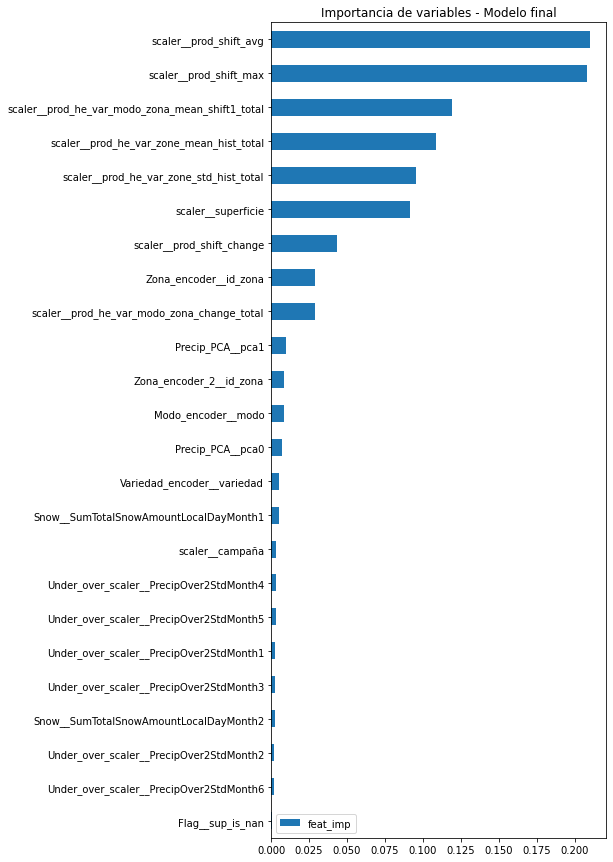

In [15]:
m.fit(X,y)

show_feat_imps(
    m[-1].feature_importances_,
    m[:-1].get_feature_names_out(),
)

plt.title('Importancia de variables - Modelo final')
plt.show()

# 5. Prediccion Final

In [16]:
data_final = tr.filter_camp(data, min_camp=22, max_camp=22)
X_final, y_final = tr.xy_split(data_final)

In [17]:
preds_final = data_final[['id_finca', 'variedad','modo','tipo','color','superficie']].copy()
preds_final['produccion'] = m.predict(X_final)
preds_final = preds_final.sort_values(['id_finca', 'variedad','modo','tipo','color','superficie'], ascending=True)

In [18]:
preds_final.to_csv('../data/final/Malbecs.txt', sep="|", header=None, index=False)

# 6. Explicabilidad y análisis de errores

### Explicabilidad

Para  una  mejor  adopción  de  la  IA  los  modelos  deber  ser  explicables,  debemos 
evitar hablar de modelos de  caja blanca / negra. 

En el desarrollo de  todo modelo 
debe tenerse en cuenta la explicabilidad desde el diseño, un modelo explicable se 
integra en la gestión de  forma más rápida que  uno que  no lo es, incluso modelos 
no  explicables  pueden  llegar  a  no  utilizarse  nunca  aun  teniendo  una  muy  buena 
precisión.

Nuestro mejor modelo fue creado utilizando el algoritmo **Random Forest**. Creemos que este algoritmo tiene una alta capacidad de predicción como tambien de explicabilidad. Nos pareció un buen punto medio entre modelos simples como regresiones lineales y redes neuronales, donde la explicabilidad es menor.

A partir de librerias como **Shap**, podemos visualizar la explicabilidad a partir de gráficos interesantes.

#### Análisis de errores

Primero que nada, observamos la relación entre predicciones y variables reales para 2021

In [19]:
train, test = tr.train_test_split(data_train, test_camp=21)
X_train, y_train = tr.xy_split(train)
X_test, y_test = tr.xy_split(test)

cat_cols = [
    'id_finca',
    'id_zona',
    'id_estacion',
    'variedad',
    "modo",
    "tipo",
    "color",
    "prod_shift1_gt_shift2",
    "sup_is_nan",
]


X_train[cat_cols] = X_train[cat_cols].astype('category')
X_test[cat_cols] = X_test[cat_cols].astype('category')

In [20]:
m = mm.get_final_model()
m

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Flag',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['sup_is_nan']),
                                                 ('Zona_encoder',
                                                  TargetEncoder(),
                                                  ['id_zona']),
                                                 ('Zona_encoder_2',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['id_zona']),
                                                 ('Variedad_encoder',
                                                  OrdinalEncoder(handle_unk...
                                                   'SumTotalPrecipAmountLocalDayMonth4',
                                                   'SumTotalPrecipAmountLocalDayMonth5',
                                                   'SumTotalPrecipAmountLocalDayMonth6']),
                                                 ('Snow', StandardScaler(),
                                                  ['SumTotalSnowAmountLocalDayMonth1',
                                                   'SumTotalSnowAmountLocalDayMonth2'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features=0.2, max_samples=0.8,
                                       min_samples_leaf=4, n_estimators=500,
                                       n_jobs=-1, random_state=42))])

In [21]:
m.fit(X_train,y_train)

preds_21 = m.predict(X_test)

Vemos que para los valores mas altos, el modelo tiene una peor performance

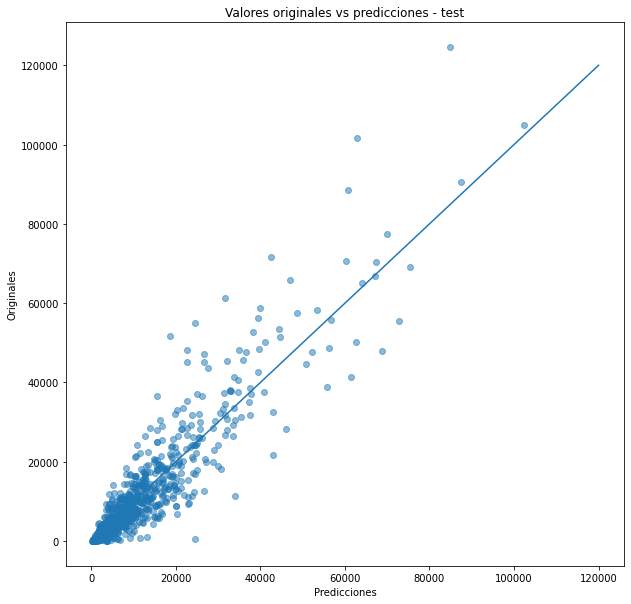

In [22]:
plt.figure(figsize=(10,10))
plt.scatter(preds_21, y_test, alpha=0.5)
plt.plot( [0,120000],[0,120000] )
plt.xlabel('Predicciones')
plt.ylabel('Originales')
plt.title('Valores originales vs predicciones - test')
plt.show()

Errores para Train

Creamos dataframe para ver los errores- absolutos y porcentuales- según variables originales

In [23]:
df_errores = X_train.copy()
df_errores['prediccion'] = m.predict(X_train)
df_errores['produccion'] = y_train
df_errores['error'] = abs(df_errores.prediccion - df_errores.produccion)
df_errores['error_p'] = (df_errores.error / df_errores.produccion) *100

Los errores absolutos se encuentran cerca del 0 para el set de entrenamiento, llegando a valores de 15000

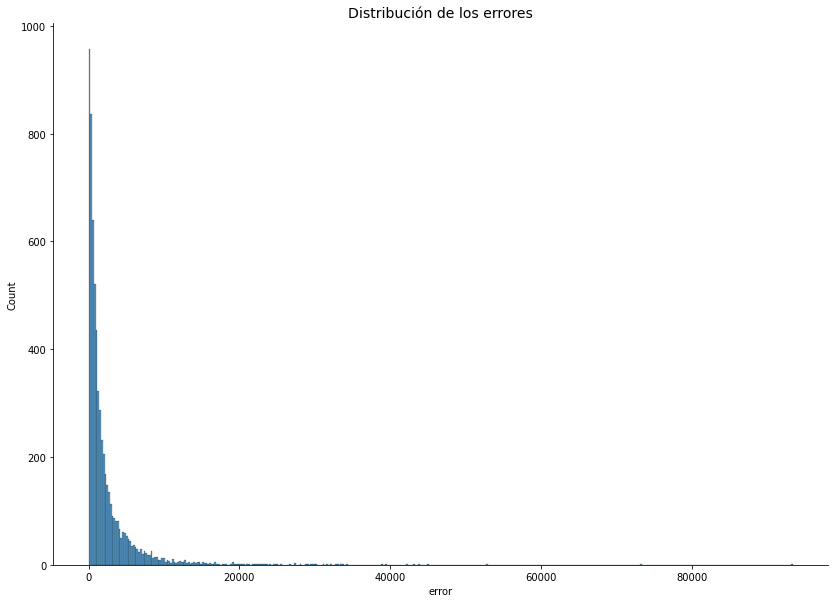

In [24]:
sns.displot(df_errores.error, height=8.27, aspect=11.7/8.27)
plt.title('Distribución de los errores', fontsize=14)
plt.show()

El orden de variables correlacionadas con el error es parecido a aquel de importancia de variables comentado previamente, dandole mayor entidad a las producciones pasadas e hipoteticas según las caracteristicas propias de la finca.

In [25]:
df_errores.corr()['error'].sort_values(ascending=False).head(20)

error                                     1.00
produccion                                0.68
prediccion                                0.61
superficie                                0.55
prod_shift_max                            0.53
prod_shift_avg                            0.53
prod_he_shift_avg_total                   0.53
prod_he_shift1_total                      0.51
prod_shift1                               0.51
prod_he_var_modo_mean_shift1_total        0.51
prod_he_var_mean_hist_total               0.50
prod_var_shift_1                          0.50
prod_he_var_mean_shift1_total             0.49
sup_shift1                                0.47
prod_shift2                               0.43
prod_he_shift2_total                      0.43
prod_he_zona_mean_shift1_total            0.42
prod_var_shift_2                          0.41
prod_he_var_modo_zona_mean_shift1_total   0.41
prod_he_var_zone_mean_hist_total          0.39
Name: error, dtype: float64

No hay una clara relacion entre errores y superficies, pero si la hay con las producciones más altas. Como se enseño previamente, el modelo encuentra mayor dificultad en predecir estas ultimas.

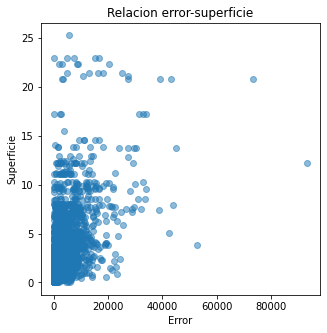

In [26]:
plt.figure(figsize=(5,5))
plt.scatter(x=df_errores.error, y=df_errores.superficie , alpha=0.5)
plt.xlabel('Error')
plt.ylabel('Superficie')
plt.title('Relacion error-superficie')
plt.show()

Tampoco hay una clara relación entre error y altitud

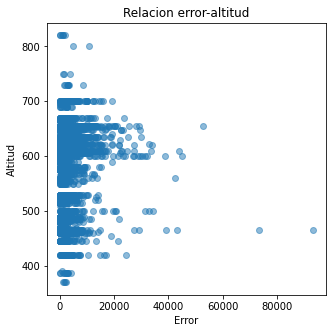

In [27]:
plt.figure(figsize=(5,5))
plt.scatter(x=df_errores.error, y=df_errores.altitud , alpha=0.5)
plt.xlabel('Error')
plt.ylabel('Altitud')
plt.title('Relacion error-altitud')
plt.show()

Así mismo, las variedades con mayor produccion tienen un mayor error de produccion. Algunas que se destacan son, por ejemplo, la variedad 32, 17 o 59. Estas son las mas comunes en el viñedo.

Errores para Test

In [28]:
df_errores_test = X_test.copy()
df_errores_test['produccion'] = y_test
df_errores_test['preds'] = m.predict(X_test)
df_errores_test['error'] = df_errores_test.produccion - df_errores_test.preds
df_errores_test['error_abs'] = abs(df_errores_test.error)
df_errores_test['error_p'] = (df_errores_test.error_abs / df_errores_test.produccion)*100
df_errores_test.head()

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,std_superficie,std_superficie_null,sup_is_nan,sup_tot_camp_finca,superficie_total,n_var_camp_finca,prod_shift1,prod_shift2,sup_shift1,sup_shift2,prod_shift1_gt_shift2,prod_shift_max,prod_shift_change,prod_shift_avg,prod_est_mean_change,prod_he_shift1,prod_he_shift2,prod_he_shift_change,prod_he_shift_avg,prod_he_var_zone_mean_hist,prod_he_var_zone_std_hist,prod_he_var_mean_hist,prod_he_var_std_hist,prod_var_shift_1,prod_var_shift_2,prod_he_var_modo_zona_mean_shift1,prod_he_var_modo_zona_std_shift1,prod_he_var_modo_zona_change,prod_he_var_modo_mean_shift1,prod_he_var_modo_std_shift1,prod_he_var_modo_change,prod_he_var_mean_shift1,prod_he_var_std_shift1,prod_he_var_change,prod_he_zona_mean_shift1,prod_he_zona_std_shift1,prod_he_zona_change,prod_finca_shift_1,prod_finca_shift_1,prod_he_shift1_total,prod_he_shift2_total,prod_he_shift_change_total,prod_he_shift_avg_total,prod_he_var_zone_mean_hist_total,prod_he_var_zone_std_hist_total,prod_he_var_mean_hist_total,prod_he_var_std_hist_total,prod_he_var_modo_zona_mean_shift1_total,prod_he_var_modo_zona_std_shift1_total,prod_he_var_modo_zona_change_total,prod_he_var_modo_mean_shift1_total,prod_he_var_modo_std_shift1_total,prod_he_var_modo_change_total,prod_he_var_mean_shift1_total,prod_he_var_std_shift1_total,prod_he_var_change_total,prod_he_zona_mean_shift1_total,prod_he_zona_std_shift1_total,prod_he_zona_change_total,year_x,ID_ESTACION_x,MeanDewpointLocalDayAvgMonth1,MeanDewpointLocalDayAvgMonth2,MeanDewpointLocalDayAvgMonth3,MeanDewpointLocalDayAvgMonth4,MeanDewpointLocalDayAvgMonth5,MeanDewpointLocalDayAvgMonth6,MeanEvapotranspirationLocalDayAvgMonth1,MeanEvapotranspirationLocalDayAvgMonth2,MeanEvapotranspirationLocalDayAvgMonth3,MeanEvapotranspirationLocalDayAvgMonth4,MeanEvapotranspirationLocalDayAvgMonth5,MeanEvapotranspirationLocalDayAvgMonth6,MeanFeelsLikeLocalDayAvgMonth1,MeanFeelsLikeLocalDayAvgMonth2,MeanFeelsLikeLocalDayAvgMonth3,MeanFeelsLikeLocalDayAvgMonth4,MeanFeelsLikeLocalDayAvgMonth5,MeanFeelsLikeLocalDayAvgMonth6,MeanGlobalHorizontalIrradianceLocalDayAvgMonth1,MeanGlobalHorizontalIrradianceLocalDayAvgMonth2,MeanGlobalHorizontalIrradianceLocalDayAvgMonth3,MeanGlobalHorizontalIrradianceLocalDayAvgMonth4,MeanGlobalHorizontalIrradianceLocalDayAvgMonth5,MeanGlobalHorizontalIrradianceLocalDayAvgMonth6,MeanGustLocalDayAvgMonth1,MeanGustLocalDayAvgMonth2,MeanGustLocalDayAvgMonth3,MeanGustLocalDayAvgMonth4,MeanGustLocalDayAvgMonth5,MeanGustLocalDayAvgMonth6,MeanMSLPLocalDayAvgMonth1,MeanMSLPLocalDayAvgMonth2,MeanMSLPLocalDayAvgMonth3,MeanMSLPLocalDayAvgMonth4,MeanMSLPLocalDayAvgMonth5,MeanMSLPLocalDayAvgMonth6,MeanPrecipAmountLocalDayAvgMonth1,MeanPrecipAmountLocalDayAvgMonth2,MeanPrecipAmountLocalDayAvgMonth3,MeanPrecipAmountLocalDayAvgMonth4,MeanPrecipAmountLocalDayAvgMonth5,MeanPrecipAmountLocalDayAvgMonth6,MeanRelativeHumidityLocalDayAvgMonth1,MeanRelativeHumidityLocalDayAvgMonth2,MeanRelativeHumidityLocalDayAvgMonth3,MeanRelativeHumidityLocalDayAvgMonth4,MeanRelativeHumidityLocalDayAvgMonth5,MeanRelativeHumidityLocalDayAvgMonth6,MeanSnowAmountLocalDayAvgMonth1,MeanSnowAmountLocalDayAvgMonth2,MeanSnowAmountLocalDayAvgMonth3,MeanSnowAmountLocalDayAvgMonth4,MeanSnowAmountLocalDayAvgMonth5,MeanSnowAmountLocalDayAvgMonth6,MeanTemperatureLocalDayAvgMonth1,MeanTemperatureLocalDayAvgMonth2,MeanTemperatureLocalDayAvgMonth3,MeanTemperatureLocalDayAvgMonth4,MeanTemperatureLocalDayAvgMonth5,MeanTemperatureLocalDayAvgMonth6,MeanUVIndexLocalDayAvgMonth1,MeanUVIndexLocalDayAvgMonth2,MeanUVIndexLocalDayAvgMonth3,MeanUVIndexLocalDayAvgMonth4,MeanUVIndexLocalDayAvgMonth5,MeanUVIndexLocalDayAvgMonth6,MeanVisibilityLocalDayAvgMonth1,MeanVisibilityLocalDayAvgMonth2,MeanVisibilityLocalDayAvgMonth3,MeanVisibilityLocalDayAvgMonth4,MeanVisibilityLocalDayAvgMonth5,MeanVisibilityLocalDayAvgMonth6,MeanWindSpeedLocalDayAvgMonth1,MeanWindSpeedLocalDayAvgMonth2,MeanWindSpeedLocalDayAvgMonth3,MeanWindSpeedLocalDayAvgMont

Vemos que en test el modelo comete errores más altos, signo de sobreajuste.

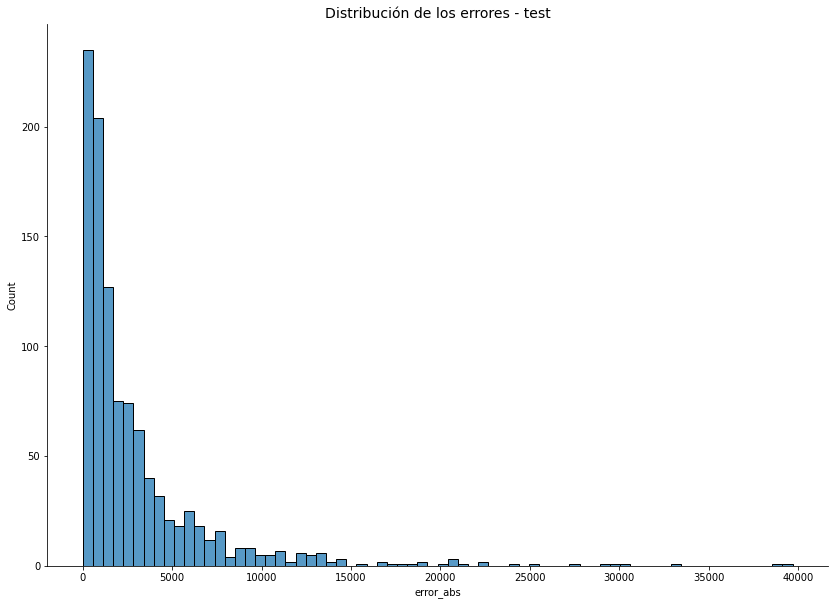

In [29]:
sns.displot(df_errores_test.error_abs, height=8.27, aspect=11.7/8.27)
plt.title('Distribución de los errores - test', fontsize=14)
plt.show()

La relación tampoco es clara entre superficie y errores en Test

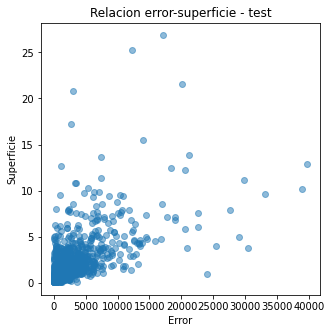

In [30]:
plt.figure(figsize=(5,5))
plt.scatter(x=df_errores_test.error_abs, y=df_errores_test.superficie , alpha=0.5)
plt.xlabel('Error')
plt.ylabel('Superficie')
plt.title('Relacion error-superficie - test')
plt.show()

Tambien podemos evaluar los modelos según la existencia previa de la finca, variedad, modo y tipo

In [31]:
#Flag para reconocer fincas nuevas

df_errores['identificador'] = df_errores.id_finca.astype(str) +  '-' +df_errores.variedad.astype(str) +  '-'+ df_errores.modo.astype(str) +  '-' +df_errores.tipo.astype(str)
df_errores_test['identificador'] = df_errores_test.id_finca.astype(str) +  '-' +df_errores_test.variedad.astype(str) +  '-'+ df_errores_test.modo.astype(str) +  '-' +df_errores_test.tipo.astype(str)

codigos = list(df_errores.identificador.unique())
exists = [1 if x in codigos else 0 for x in df_errores_test.identificador]
df_errores_test['exists_flag'] = exists

df_errores_test['exists_flag'].value_counts()

1    977
0     67
Name: exists_flag, dtype: int64

Notamos que el modelo tiene errores parecidos en terminos absolutos para nuevas y existentes fincas (teniendo en cuenta su variedad, modo y tipo)

In [32]:
df_errores_test.groupby('exists_flag')['error_abs'].agg('mean')

exists_flag
0   2694.10
1   3020.33
Name: error_abs, dtype: float64

En terminos relativos (porcentaje), incluso es mejor para nuevos casos.

In [33]:
df_errores_test.groupby('exists_flag')['error_p'].agg('mean')

exists_flag
0   325.32
1   638.19
Name: error_p, dtype: float64

### Shap Values

In [34]:
import shap
shap.initjs()

Entrenamos el modelo para 2022

In [35]:
m = mm.get_final_model()
m.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Flag',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['sup_is_nan']),
                                                 ('Zona_encoder',
                                                  TargetEncoder(),
                                                  ['id_zona']),
                                                 ('Zona_encoder_2',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['id_zona']),
                                                 ('Variedad_encoder',
                                                  OrdinalEncoder(handle_unk...
                                                   'SumTotalPrecipAmountLocalDayMonth4',
                                                   'SumTotalPrecipAmountLocalDayMonth5',
                                                   'SumTotalPrecipAmountLocalDayMonth6']),
                                                 ('Snow', StandardScaler(),
                                                  ['SumTotalSnowAmountLocalDayMonth1',
                                                   'SumTotalSnowAmountLocalDayMonth2'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features=0.2, max_samples=0.8,
                                       min_samples_leaf=4, n_estimators=500,
                                       n_jobs=-1, random_state=42))])

In [36]:
explainer = shap.TreeExplainer(m[-1])

In [37]:
x_sample = X.sample(int(0.7*X.shape[0]), random_state=seed)
x_sample_trans = pd.DataFrame(
    m[:-1].transform(x_sample),
    columns=m[:-1].get_feature_names_out(),
)

Creamos shap values y los guardamos para no correr el codigo nuevamente

In [38]:
# shap_values = explainer.shap_values(x_sample_trans)
# mm.save_trained_model(shap_values,'../data/models/shap_values.pickle')

Leemos shap values previamente construidos y guardados

In [39]:
shap_values_read = mm.load_trained_model('../data/models/shap_values.pickle')

Valores altos (rojos) de las variables de producciones pasadas y superficies, por ejemplo, otorgan una prediccion (shap value) alta de la producción.

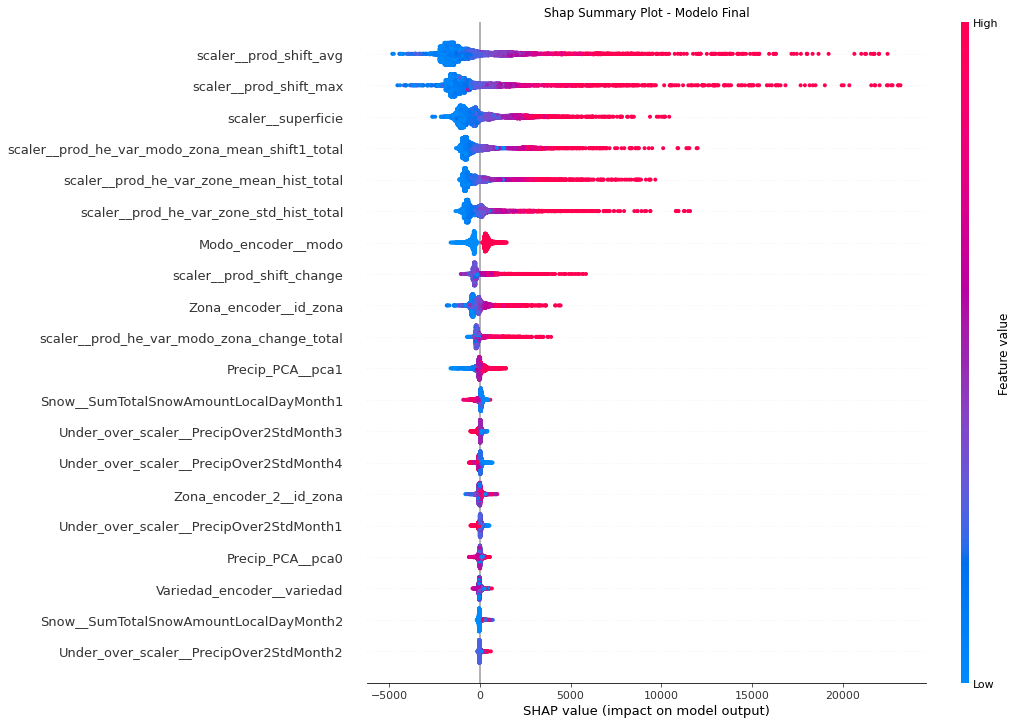

In [40]:
plt.figure(facecolor="white")
shap.summary_plot(shap_values_read, x_sample_trans, plot_size=[15,10], show = False)
plt.title("Shap Summary Plot - Modelo Final") 
plt.show()

Visualizamos una relación directa entre valores de las predicciones y los valores previos de la produccion o valores de la superficie

<Figure size 432x288 with 0 Axes>

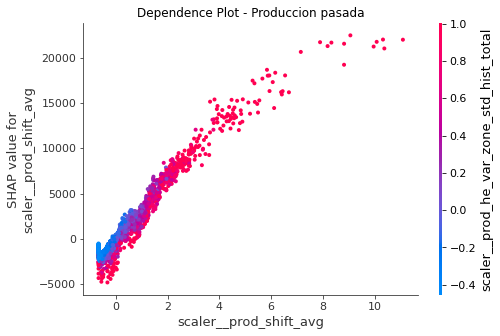

<Figure size 432x288 with 0 Axes>

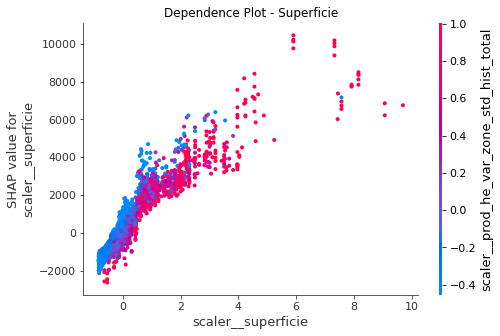

In [41]:
plt.figure(facecolor="white")
shap.dependence_plot('scaler__prod_shift_avg', shap_values_read, x_sample_trans,show=False)
plt.title("Dependence Plot - Produccion pasada") 
plt.show()

plt.figure(facecolor="white")
shap.dependence_plot('scaler__superficie', shap_values_read, x_sample_trans, show=False)
plt.title("Dependence Plot - Superficie") 
plt.show()

# 7. Justicia

La IA debe usarse de forma justa, por lo que debe de velar por la equidad y evitar 
sesgos de  cualquier tipo. En el  desarrollo de  cualquier modelo, y desde el diseño, 
debe revisarse que la muestra es lo suficientemente representativa y que no existe 
ningún sesgo (ni en los datos utilizados en el entrenamiento ni en el 
comportamiento del propio modelo).

Para esto, corroboraremos  la  suficiente  diversidad  de  la 
muestra, así como la inexistencia de sesgos. 

Por este motivo, realizamos arriba un analisis de los errores cometidos por los modelos, evaluandolos por distintas variables explicativas que puedan llegar a estar afectandolo.

Así mismo, cabe recordar que nuestro modelo final **no discrimina en terminos de identificadores de fincas**.
Es decir, no tomamos la variable id_finca como variable explicativa. Esto ayuda tambien para que, en caso que se incorpore una nueva finca al viñedo, la prediccion no sea irregular.
Este punto se comprobó previamente, en el analisis de los errores, donde enseñamos que para aquellas fincas nuevas- teniendo en cuenta tambien su variedad, modo y tipo-, el error era menor en terminos absolutos y porcentuales.

Comenzamos evaluando las distribuciones en el entrenamiento y validación. Para esto, cargamos los datasets finales y hacemos el split.

Recordar que realizamos el split en una forma temporal. Es decir, si el set de validación es 2021, el de entrenamiento serán todos los datos que sean de campañas anteriores a esta.

Evaluamos entrenamiento y validación para las variables mas importantes del modelo.

- El promedio de producción y superficie no presenta diferencias en ambos grupos.

In [42]:
print(f'El set de entrenamiento cuenta con {X_train.shape[0]} registros, mientras que el set de validación con {X_test.shape[0]} registros.')

El set de entrenamiento cuenta con 6334 registros, mientras que el set de validación con 1044 registros.


In [43]:
print(f'El promedio de la producción en uno y el otro es de {round(y_train.mean(),2)}kg y {round(y_test.mean(),2)}kg, respectivamente.')

El promedio de la producción en uno y el otro es de 9301.91kg y 9964.51kg, respectivamente.


In [44]:
print(f'El promedio de la superficie en uno y el otro es de {round(X_train.superficie.mean(),2)} hectarias y {round(X_test.superficie.mean(),2)} hectarias, respectivamente.')

El promedio de la superficie en uno y el otro es de 2.14 hectarias y 2.17 hectarias, respectivamente.


Tambien notamos que hay variedades de vino que tienen menores producciones y superficies, pero puede notarse una relacion entre estas dos ultimas.

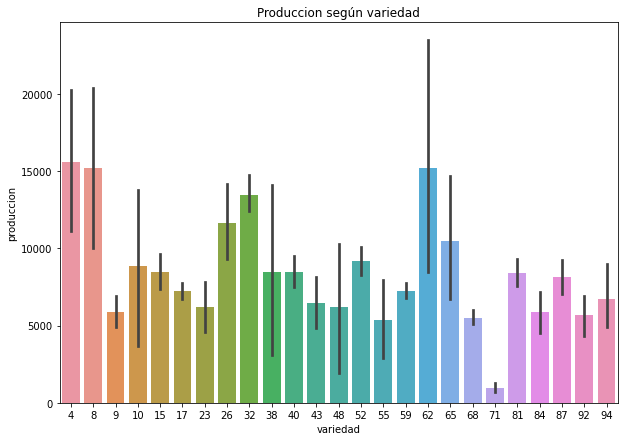

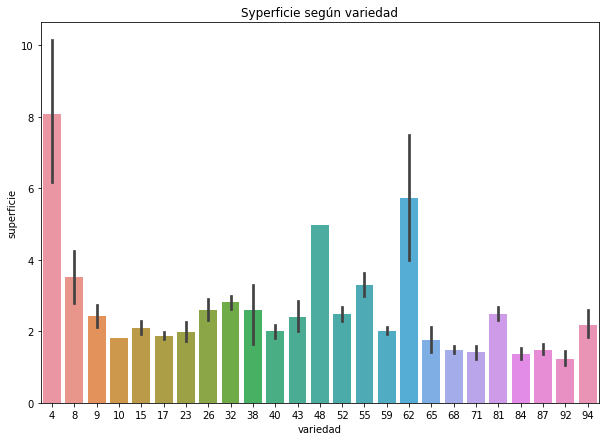

In [45]:
plt.figure(figsize=(10,7))
sns.barplot(data=data, x='variedad',y='produccion')
plt.title('Produccion según variedad')
plt.show()

plt.figure(figsize=(10,7))
sns.barplot(data=data, x='variedad',y='superficie')
plt.title('Syperficie según variedad')
plt.show()

Ahora revisamos el bias de las predicciones.

Podemos evaluar las predicciones del modelo según la superficie de las fincas. Esto lo podemos realizar separandolas en percentiles:

In [46]:
Q1 = data_final.superficie.quantile(0.25)
Q2 = data_final.superficie.quantile(0.5)
Q3 = data_final.superficie.quantile(0.75)

Q1,Q2,Q3

(0.6126499999999999, 1.3, 2.7095000000000002)

In [47]:
bias_df = data_final.copy()
bias_df['preds'] = m.predict(X_final)

bias_df['sup_q'] = [0 if x < Q1 else 1 if x < Q2 else 2 if x < Q3 else 3 for x in bias_df.superficie]

bias_df = bias_df[['superficie','sup_q','preds']]

Aunque no hay una relacion directa entre superficie y producción...

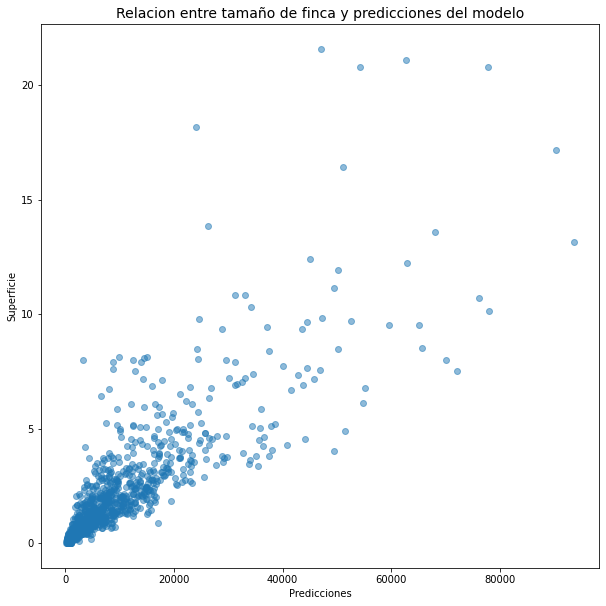

In [49]:
plt.figure(figsize=(10,10))
plt.scatter(x=bias_df.preds, y=bias_df.superficie , alpha=0.5)
plt.xlabel('Predicciones')
plt.ylabel('Superficie')
plt.title('Relacion entre tamaño de finca y predicciones del modelo', fontsize=14)
plt.show()

...si la hay entre el percentil de esta y las predicciones.

Sin embargo, no consideramos esto como un bias, ya que el tamaño de una finca es clave para conocer el potencial de producción que esta pueda tener.

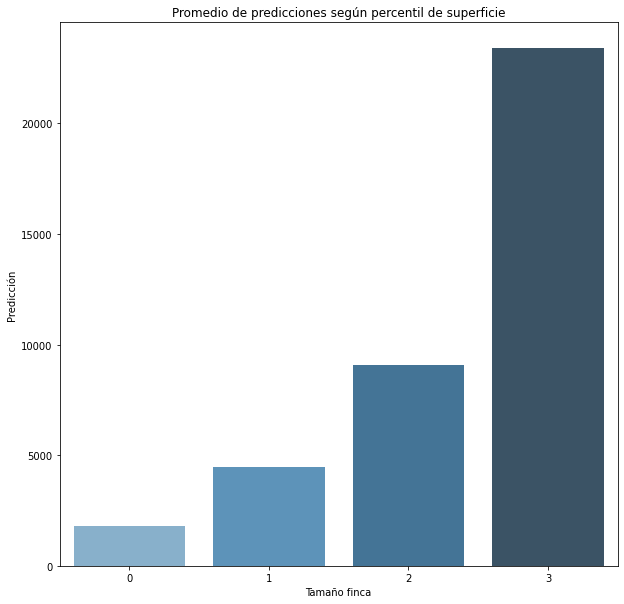

In [50]:
bias_avg = bias_df.groupby('sup_q')['preds'].agg('mean').reset_index()
plt.figure(figsize=(10,10))
sns.barplot(data=bias_avg, x='sup_q', y='preds',palette='Blues_d')
plt.xlabel('Tamaño finca')
plt.ylabel('Predicción')
plt.title('Promedio de predicciones según percentil de superficie')
plt.show()